# Toy examples of ball mapper


This notebook was prepared originally by Davide Gurnari in Python. 

## Generate data

In [8]:
using LinearAlgebra
using Plots
using Graphs
using GraphPlot
using Random
using Statistics

In [9]:
rng = MersenneTwister(1234)

MersenneTwister(1234)

We will start by constructing a collection of points sampled from a unit circle.

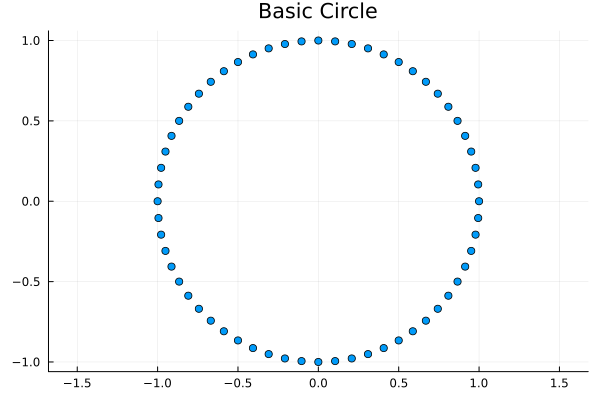

In [10]:
points = hcat([[cos(θ), sin(θ)] for θ in LinRange(0, 2π, 61)[1:end-1]]...)
scatter(points[1,:], points[2,:]; aspect_ratio=1, legend=false, title="Basic Circle")

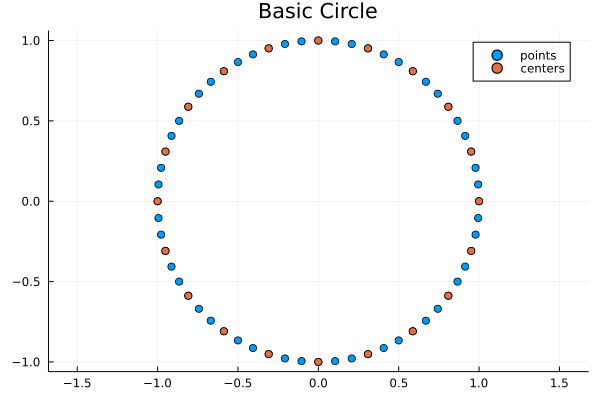

In [11]:
function find_centers( points, ϵ )
    centers = Dict{Int, Int}() # dict of points {idx_v: idx_p, ... }
    centers_counter = 1
    
    for (idx_p, p) in enumerate(eachcol(points))
        
        is_covered = false

        for idx_v in keys(centers)
            distance = norm(p .- points[:, centers[idx_v]])
            if distance <= ϵ
                is_covered = true
                break
            end
        end

        if !is_covered
            centers[centers_counter] = idx_p
            centers_counter += 1
        end
        
    end
    return centers
end
ϵ = 0.25
centers = find_centers( points, ϵ )
idxs = collect(values(centers))
scatter(points[1,:], points[2,:]; aspect_ratio=1,  label = "points", title="Basic Circle")
scatter!(points[1,idxs], points[2,idxs]; aspect_ratio=1, label="centers")

In [12]:
function compute_points_covered_by_landmarks( points, centers :: Dict{Int, Int}, ϵ)
    points_covered_by_landmarks = Dict{Int,Vector{Int}}()
    for idx_v in keys(centers)
        points_covered_by_landmarks[idx_v] = Int[]
        for (idx_p, p) in enumerate(eachcol(points))
            distance = norm(p .- points[:,centers[idx_v]])
            if distance <= ϵ
                push!(points_covered_by_landmarks[idx_v], idx_p)
            end
        end
    end
    return sort(points_covered_by_landmarks)
end
points_covered_by_landmarks = compute_points_covered_by_landmarks( points, centers, ϵ)

OrderedCollections.OrderedDict{Int64, Vector{Int64}} with 20 entries:
  1  => [1, 2, 3, 59, 60]
  2  => [2, 3, 4, 5, 6]
  3  => [5, 6, 7, 8, 9]
  4  => [8, 9, 10, 11, 12]
  5  => [11, 12, 13, 14, 15]
  6  => [14, 15, 16, 17, 18]
  7  => [17, 18, 19, 20, 21]
  8  => [20, 21, 22, 23, 24]
  9  => [23, 24, 25, 26, 27]
  10 => [26, 27, 28, 29, 30]
  11 => [29, 30, 31, 32, 33]
  12 => [32, 33, 34, 35, 36]
  13 => [35, 36, 37, 38, 39]
  14 => [38, 39, 40, 41, 42]
  15 => [41, 42, 43, 44, 45]
  16 => [44, 45, 46, 47, 48]
  17 => [47, 48, 49, 50, 51]
  18 => [50, 51, 52, 53, 54]
  19 => [53, 54, 55, 56, 57]
  20 => [56, 57, 58, 59, 60]

In [13]:
function ball_mapper_graph(centers, points_covered_by_landmarks)
    nv = length(centers)
    graph = Graph(nv)
    idxs = collect(keys(centers))
    for (i, idx_v) in enumerate(idxs[1:end-1]), idx_u in idxs[i+1:end]
        if !isdisjoint(points_covered_by_landmarks[idx_v], points_covered_by_landmarks[idx_u])
            add_edge!( graph, idx_v, idx_u )
        end
    end
    return graph
end   

ball_mapper_graph (generic function with 1 method)

In [14]:
graph = ball_mapper_graph(centers, points_covered_by_landmarks)

{20, 20} undirected simple Int64 graph

In [15]:
function vertices_positions(points, points_covered_by_landmarks)
    loc_x = Float64[]
    loc_y = Float64[]
    for i in keys(points_covered_by_landmarks)
        push!(loc_x, mean(view(points, 1, points_covered_by_landmarks[i])))
        push!(loc_y, mean(view(points, 2, points_covered_by_landmarks[i])))
    end
    return loc_x, loc_y
end
loc_x, loc_y = vertices_positions(points, points_covered_by_landmarks)

([0.9890677984408317, 0.9406593747648543, 0.8001726575276479, 0.5813594654409051, 0.30563875830723225, 1.942890293094024e-16, -0.30563875830723186, -0.5813594654409049, -0.8001726575276477, -0.9406593747648543, -0.9890677984408315, -0.9406593747648546, -0.8001726575276482, -0.5813594654409056, -0.30563875830723297, -8.881784197001252e-16, 0.3056387583072316, 0.5813594654409047, 0.8001726575276473, 0.9406593747648542], [-2.831068712794149e-16, 0.3056387583072321, 0.5813594654409051, 0.8001726575276479, 0.9406593747648545, 0.9890677984408317, 0.9406593747648545, 0.800172657527648, 0.5813594654409054, 0.30563875830723247, 2.9420910152566647e-16, -0.3056387583072317, -0.5813594654409047, -0.8001726575276475, -0.9406593747648542, -0.9890677984408317, -0.9406593747648546, -0.8001726575276482, -0.581359465440906, -0.30563875830723297])

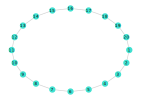

In [16]:
nv = length(centers)
gplot(graph, loc_x, loc_y, nodelabel=collect(keys(points_covered_by_landmarks)))

In [17]:
function compute_colors(points, points_covered_by_landmarks)
    n = size(points, 2)
    colors = zeros(Int, n)
    for (i, cluster) in enumerate(values(points_covered_by_landmarks))
        colors[cluster] .= i
    end
    return colors
end

compute_colors (generic function with 1 method)

In [18]:
function noisy_circle(rng, n, noise=0.05)
    x = zeros(n)
    y = zeros(n)
    for i in 1:n
        θ = 2π * rand(rng)
        x[i] = cos(θ) + 2 * noise * (rand(rng) - 0.5)
        y[i] = sin(θ) + 2 * noise * (rand(rng) - 0.5)
    end
    
    return vcat(x', y')
end

noisy_circle (generic function with 2 methods)

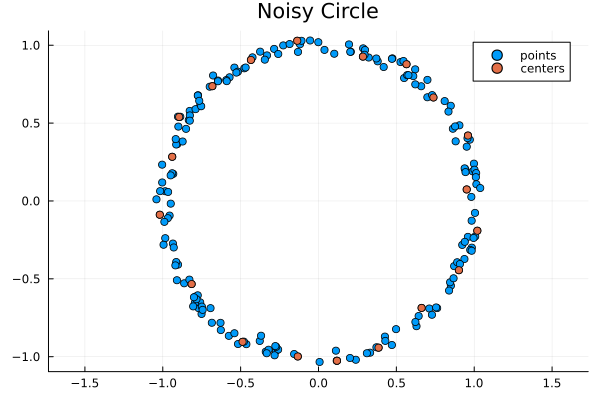

In [19]:
points = noisy_circle(rng, 200)
ϵ = 0.25
centers = find_centers( points, ϵ )
idxs = collect(values(centers))
scatter(points[1,:], points[2,:]; aspect_ratio=1,  label = "points", title="Noisy Circle")
scatter!(points[1,idxs], points[2,idxs]; aspect_ratio=1, label="centers")

In [20]:
points_covered_by_landmarks = compute_points_covered_by_landmarks( points, centers, ϵ)

OrderedCollections.OrderedDict{Int64, Vector{Int64}} with 19 entries:
  1  => [1, 4, 22, 36, 40, 66, 70, 83, 92, 109, 121, 126, 139, 140, 142, 144, 1…
  2  => [2, 39, 46, 48, 50, 53, 64, 128, 138, 143, 161, 162, 173, 174, 194]
  3  => [3, 23, 42, 54, 62, 98, 108, 122, 124, 165, 177, 180, 183, 189, 192]
  4  => [5, 7, 27, 38, 43, 61, 71, 76, 88, 101, 110, 113, 117, 133, 155, 169, 1…
  5  => [6, 16, 26, 28, 38, 45, 73, 84, 101, 117, 131, 133, 150, 152, 184, 186,…
  6  => [8, 37, 59, 72, 75, 82, 85, 95, 96, 103, 107, 112, 114, 116, 160]
  7  => [9, 25, 32, 58, 93, 125, 130, 134, 147, 148]
  8  => [10, 19, 41, 44, 49, 57, 67, 69, 77, 89, 129, 136, 145, 164, 179, 187, …
  9  => [11, 37, 51, 59, 72, 75, 81, 82, 85, 87, 95, 96, 107, 116, 160, 170, 18…
  10 => [12, 27, 43, 71, 76, 103, 110, 112, 113, 114, 119, 127, 154, 155]
  11 => [13, 35, 55, 78, 79, 99, 102, 132, 141, 182, 191, 195]
  12 => [14, 51, 56, 58, 80, 81, 86, 153, 167, 172, 181, 188]
  13 => [15, 17, 24, 33, 41, 57, 67, 69, 77, 8

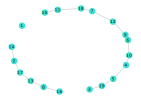

In [21]:
loc_x, loc_y = vertices_positions(points, points_covered_by_landmarks)
graph = ball_mapper_graph(centers, points_covered_by_landmarks)
nv = length(centers)
gplot(graph, loc_x, loc_y, nodelabel=collect(keys(points_covered_by_landmarks)))

In [22]:
using InvertedIndices

In [23]:
function remove_outliers(points_covered_by_landmarks, ϵ)
    # find points that ar alone in a cluster
    outliers = Int[]
    for (k,v) in points_covered_by_landmarks
        if length(v) < 3
            push!(outliers, first(v))
        end
    end
    find_centers( points[:,Not(outliers)], ϵ )
end

remove_outliers (generic function with 1 method)

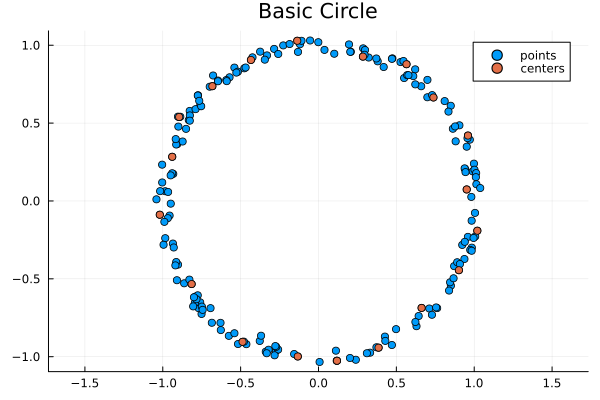

In [24]:
new_centers = remove_outliers(points_covered_by_landmarks, ϵ)
idxs = collect(values(new_centers))
scatter(points[1,:], points[2,:]; aspect_ratio=1,  label = "points", title="Basic Circle")
scatter!(points[1,idxs], points[2,idxs]; aspect_ratio=1, label="centers")

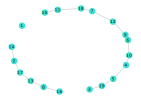

In [25]:
points_covered_by_landmarks = compute_points_covered_by_landmarks( points, new_centers, ϵ)
loc_x, loc_y = vertices_positions(points, points_covered_by_landmarks)
graph = ball_mapper_graph(new_centers, points_covered_by_landmarks)
nv = length(new_centers)
gplot(graph, loc_x, loc_y, nodelabel=collect(keys(points_covered_by_landmarks)))

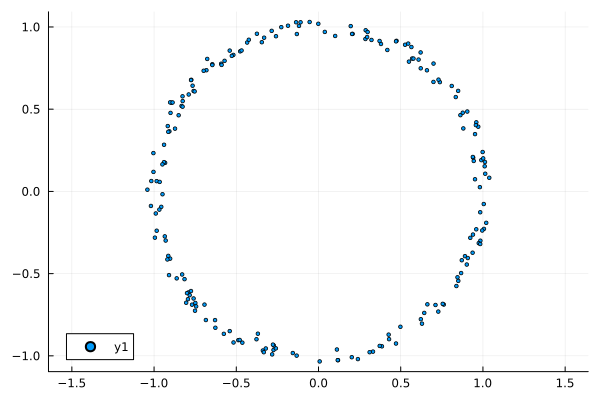

In [28]:
struct BallMapper
    
    centers :: Dict{Int, Int}
    colors :: Vector{Int}
    graph :: SimpleGraph
    loc_x :: Vector{Float64}
    loc_y :: Vector{Float64}
    
    function BallMapper(points, ϵ)
        
        centers = find_centers( points, ϵ )
        points_covered_by_landmarks = compute_points_covered_by_landmarks( points, centers, ϵ)         
        graph = ball_mapper_graph(centers, points_covered_by_landmarks)  
        loc_x, loc_y = vertices_positions(points, points_covered_by_landmarks)
        colors = compute_colors(points, points_covered_by_landmarks)
        new(centers, colors, graph, loc_x, loc_y)
    end

end

signal = 500
noise = 50
dimension = 2
noise_min = -5
noise_max = 5
σ = 0.01
scatter(points[1,:], points[2,:], ms = 2, aspect_ratio = 1)

In [29]:
bm = BallMapper(points, 1.) # the

BallMapper(Dict(5 => 32, 4 => 17, 2 => 3, 3 => 8, 1 => 1), [1, 4, 2, 1, 3, 3, 3, 3, 5, 4  …  5, 2, 2, 4, 5, 4, 4, 4, 4, 1], SimpleGraph{Int64}(5, [[4, 5], [3, 4], [2, 5], [1, 2], [1, 3]]), [-0.7186552367064089, 0.2309918773873126, 0.8408672473475545, -0.6776587840398719, 0.15773215360419796], [-0.45640567980118385, 0.7799344885696536, -0.13350539142143783, 0.5006785638663744, -0.816503286560547])

In [30]:
nv = length(bm.centers)

5

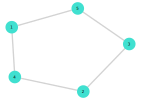

In [31]:
gplot(bm.graph, bm.loc_x, bm.loc_y, nodelabel=1:nv)

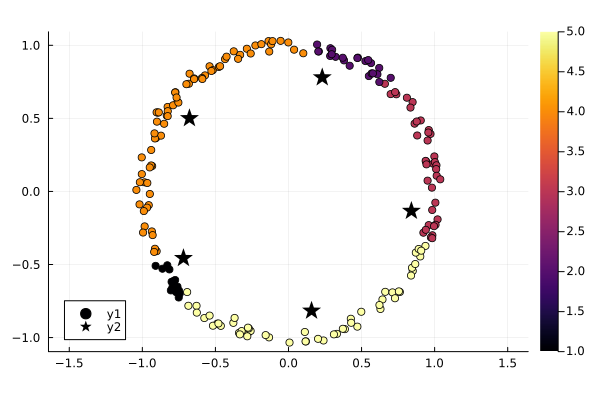

In [33]:
scatter(points[1,:], points[2, :], marker_z = bm.colors, palette = :rainbow )
scatter!(bm.loc_x, bm.loc_y, aspect_ratio = 1, marker = :star, markersize = 10, markercolor = :black)